In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=0a5d9d992a94d5d91842fed5c95b9032b30f958931a6774f6482a7fbd49f3229
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
import torch

# Paths to your saved models
path_resnet = '/content/drive/MyDrive/Models_Project/model_ResNet101.pth'
path_densenet = '/content/drive/MyDrive/Models_Project/model_DenseNet201.pth'
path_vit = '/content/drive/MyDrive/Models_Project/model_ViT.pth'
path_efficient = '/content/drive/MyDrive/Models_Project/model_efficientnetB0.pth'
path_resnet50 = '/content/drive/MyDrive/Models_Project/model_resnet50.pth'
path_mobilenetv2 = '/content/drive/MyDrive/Models_Project/model_mobilenetV2.pth'
# Load the models
model_ResNet101 = torch.load(path_resnet)
model_DenseNet201 = torch.load(path_densenet)
model_ViT = torch.load(path_vit)
model_ResNet50 = torch.load(path_resnet50)
model_efficeintB0 = torch.load(path_efficient)
model_mobilenetv2 = torch.load(path_mobilenetv2)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
train_dataset = datasets.ImageFolder("/content/drive/MyDrive/ISIC2016 original/train", transform=transform)
test_dataset = datasets.ImageFolder("/content/drive/MyDrive/ISIC2016 original/test", transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, model_A, model_B, model_C, weights):
        super(EnsembleModel, self).__init__()
        self.model_A = model_A
        self.model_B = model_B
        self.model_C = model_C
        self.weights = weights

    def forward(self, x):
        output_A = self.model_A(x)
        output_B = self.model_B(x)
        output_C = self.model_C(x)
        return self.weights[0] * output_A + self.weights[1] * output_B + self.weights[2] * output_C

# Instantiate the ensemble model with trained models and weights
ensemble_model = EnsembleModel(model_ResNet101, model_DenseNet201, model_ViT, [0.25, 0.5, 0.25])




In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(ensemble_model, test_loader, device):
    ensemble_model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ensemble_model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # # Calculate metrics
    # accuracy = accuracy_score(true_labels, predicted_labels)
    # precision = precision_score(true_labels, predicted_labels, average='weighted')
    # recall = recall_score(true_labels, predicted_labels, average='weighted')
    # f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Extracting TP, FP, FN, and TN from the confusion matrix
    TP = cm[0, 0]
    FN = cm[0, 1]
    FP = cm[1, 0]
    TN = cm[1, 1]

    # Calculate Accuracy
    accuracy = (TP + TN) / float(TP + TN + FP + FN)

    # Calculate Precision
    precision = TP / float(TP + FP) if (TP + FP) != 0 else 0

    # Calculate Recall
    recall = TP / float(TP + FN) if (TP + FN) != 0 else 0

    # Calculate F1 Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # print(f'Accuracy: {accuracy * 100:.2f}%')
    #       print(f'Precision: {precision * 100:.2f}%')
    #       print(f'Recall: {recall * 100:.2f}%')
    #       print(f'F1 Score: {f1_score * 100:.2f}%')

    return accuracy, precision, recall, f1, cm

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


model_resnet101 - Accuracy: 0.8232, Precision: 0.8338, Recall: 0.9737, F1 Score: 0.8983


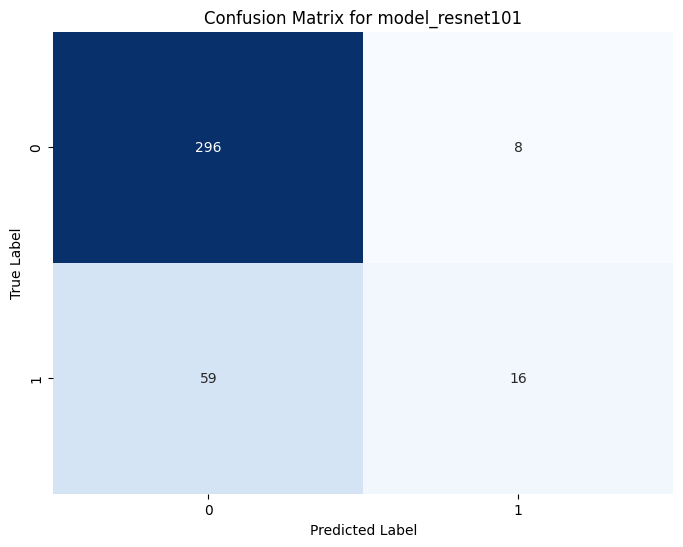

model_resnet50 - Accuracy: 0.8575, Precision: 0.8676, Recall: 0.9704, F1 Score: 0.9161


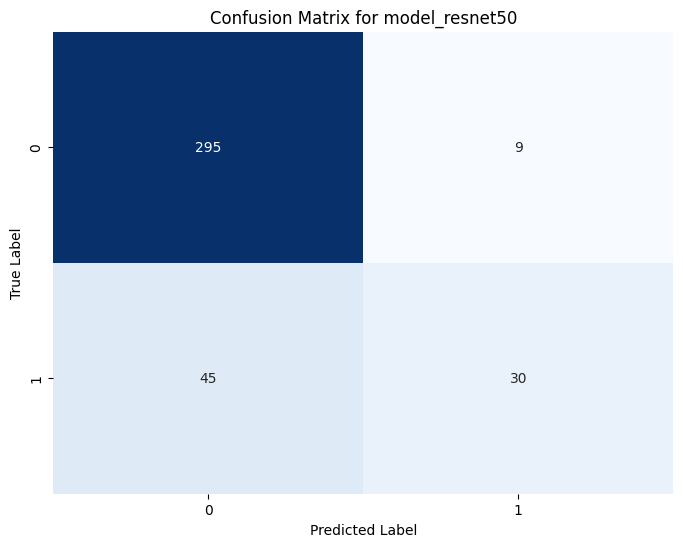

model_densenet201 - Accuracy: 0.8549, Precision: 0.8716, Recall: 0.9605, F1 Score: 0.9139


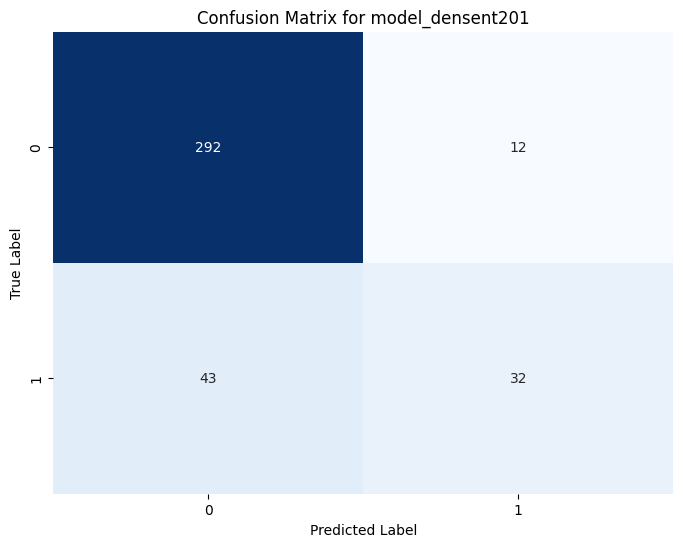

model_eff - Accuracy: 0.8338, Precision: 0.8555, Recall: 0.9539, F1 Score: 0.9020


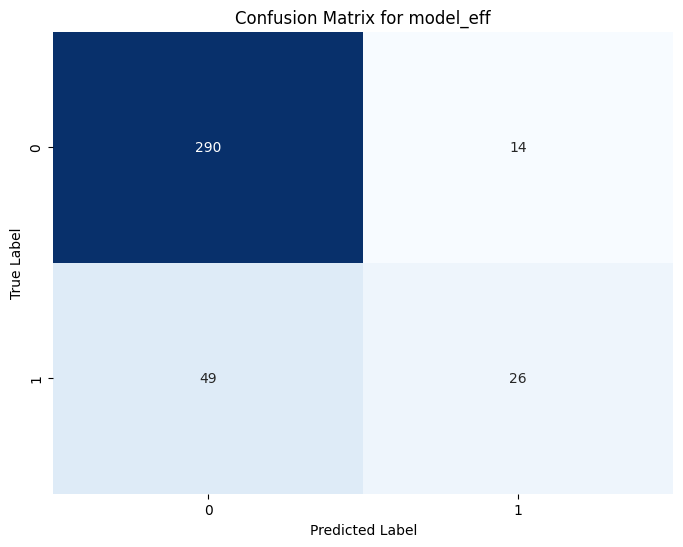

model_eff - Accuracy: 0.7916, Precision: 0.8594, Recall: 0.8849, F1 Score: 0.8720


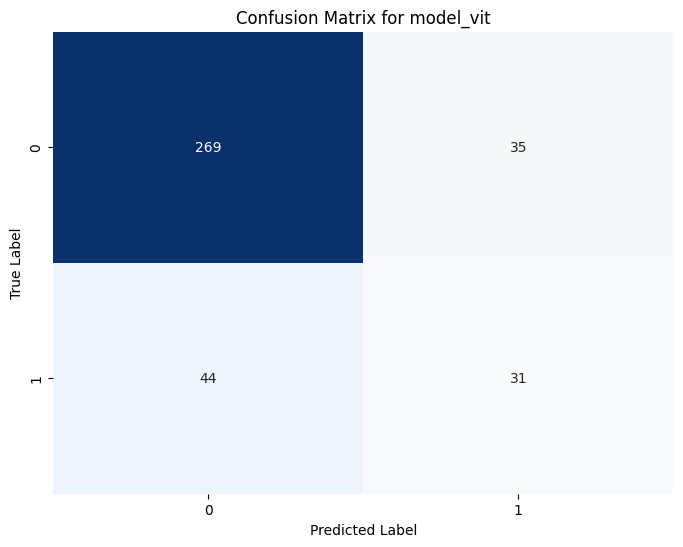

model_mob - Accuracy: 0.7995, Precision: 0.8904, Recall: 0.8553, F1 Score: 0.8725


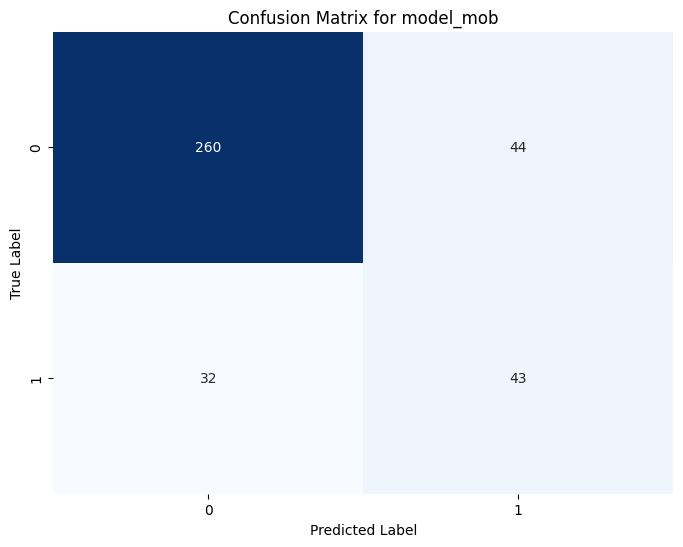

In [ ]:
accuracy, precision, recall, f1, cm = evaluate_model(model_ResNet101, test_loader, device)
print(f'model_resnet101 - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
plot_confusion_matrix(cm, 'Confusion Matrix for model_resnet101')
accuracy, precision, recall, f1, cm = evaluate_model(model_ResNet50, test_loader, device)
print(f'model_resnet50 - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
plot_confusion_matrix(cm, 'Confusion Matrix for model_resnet50')
accuracy, precision, recall, f1, cm = evaluate_model(model_DenseNet201, test_loader, device)
print(f'model_densenet201 - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
plot_confusion_matrix(cm, 'Confusion Matrix for model_densent201')
accuracy, precision, recall, f1, cm = evaluate_model(model_efficeintB0, test_loader, device)
print(f'model_eff - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
plot_confusion_matrix(cm, 'Confusion Matrix for model_eff')
accuracy, precision, recall, f1, cm = evaluate_model(model_ViT, test_loader, device)
print(f'model_eff - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
plot_confusion_matrix(cm, 'Confusion Matrix for model_vit')
accuracy, precision, recall, f1, cm = evaluate_model(model_mobilenetv2, test_loader, device)
print(f'model_mob - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
plot_confusion_matrix(cm, 'Confusion Matrix for model_mob')




In [ ]:
# model_1 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9,1.0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.05, 0.95]
# model_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9,1.0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.05, 0.95]
# model_3 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9,1.0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.05, 0.95]

# res = [[i, j, k] for i in model_1
#                 for j in model_2
#                 for k in model_3 if i + j + k == 1]

In [ ]:
# import csv

# # File path of the CSV file to save the results
# results_file_path = '/content/drive/MyDrive/Models_Project/Results/ensemble_Resnet101_DenseNet_VIT_results.csv'

# # Create a blank CSV file with the header
# with open(results_file_path, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     # Write the header row
#     writer.writerow(['Ensemble Ratio', 'Resnet101 Weight', 'DenseNet201 Weight', 'ViT Weight', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])


In [ ]:
# with open(results_file_path, mode='a', newline='') as file:
#     writer = csv.writer(file)

#     for i in range(len(res)):
#         # Instantiate the ensemble model with trained models and weights
#         ensemble_model = EnsembleModel(model_ResNet101, model_DenseNet201, model_ViT, [res[i][0], res[i][1], res[i][2]])

#         accuracy, precision, recall, f1, cm = evaluate_model(ensemble_model, test_loader, device)

#         # Write the results to the CSV file
#         writer.writerow([[res[i][0], res[i][1], res[i][2]], res[i][0], res[i][1], res[i][2], accuracy, precision, recall, f1])

#         # Optional: Print the results
#         print(f'Ensemble(Ratio):Resnet101:{res[i][0]} DenseNet201:{res[i][1]} VIT:{res[i][2]}  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
#         # plot_confusion_matrix(cm, 'Confusion Matrix for Ensemble Model')